### Imports necesarios

In [1]:
# Useful libraries.
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

# Metrics.
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn import metrics

# To prevent some warnings.
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
# Global variables
cutsAmount = 50
processorsAmount = 10

### Miscellaneous functions

In [3]:
# Read a cut of the dataset, it assumes that there is going to be four files in the directory,
#   called "xTrain", "xTest", "yTrain", "yTest".
def readCut(dir):
    xTrain = pd.read_csv("{}/xTrain.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    yTrain = pd.read_csv("{}/yTrain.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    xTest  = pd.read_csv( "{}/xTest.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    yTest  = pd.read_csv( "{}/yTest.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")

    return xTrain, yTrain, xTest, yTest

# Entries names for the result dictionary.
_accuracy   = "Accuracy"
_precision  = "Precision"
_recall     = "Recall"
_f1         = "F1"
_auc        = "AUC"
_timefit    = "Refit Time"
_model      = "Model"
_min_iter   = "min_cut_iter" 
_max_iter   = "max_cut_iter" 
_model_min  = "model_min"
_model_max  = "model_max"

#Dictionary for visualization ROC
_vis_minMetrics  =   "minMetrics" 
_vis_minModel    =   "minModel" 
_vis_maxMetrics  =   "maxMetrics"
_vis_maxModel    =   "maxModel" 
_vis_pathMin     =   "pathMin"  
_vis_pathMax     =   "pathMax"  

# Metrics array.
_metrics = [_accuracy, _precision, _recall, _f1, _auc, _timefit]

# Names of the feature enginereed datasets.
_normalized   = "Normalized"
_standardized = "Standardized"
_betterFE     = "BetterFE"

# Datasets array.
_datasets = [_normalized, _standardized, _betterFE]

# Entries names for the calculated results.
_min  = "Min"
_max  = "Max"
_mean = "Mean"

# Entries names for the test or train results.
_testResults  = "Test Results"
_trainResults = "Train Results"

# Function to process the results of a model, to get a better print of them.
def processAlgorithmResults(resultDictionary, whichSet):

    # Result dictionary
    calculatedResultsDictionary = {}
    # Process the results for every feature engineed dataset.
    for dataset in _datasets:
        # Set the current dataset entry.
        calculatedResultsDictionary[dataset] = {}

        # Process every metric.
        for metric in _metrics:
            # Store the metric values.
            metricValues = []
            classifiers = []

            # Process the results for every cut.
            for cut in resultDictionary[dataset]:
                # Get the specific metric value for the current cut.
                metricValues.append(cut[whichSet][metric])
                classifiers.append(cut[whichSet][_model])

            # Get the calculated results.
            min_it = np.argmin(metricValues)
            max_it = np.argmax(metricValues)
            calculatedResultsDictionary[dataset][metric] = {
                _min        : min(metricValues),
                _max        : max(metricValues),
                _mean       : sum(metricValues) / len(metricValues),
                _min_iter   : int(min_it + 1),
                _max_iter   : int(max_it + 1),
                _model_min  : classifiers[min_it],
                _model_max  : classifiers[max_it]
            }

    return calculatedResultsDictionary

# Print the calculated results in a tabular form from the calculated results dictionary.
def plotCalculatedResults(calculatedResults):
    # Print the results for every dataset.
    for dataset in _datasets:

        print(dataset, "dataset metrics summary")

        # Create a panda frame to pretty print.
        frame = pd.DataFrame(calculatedResults[dataset])
        
        # Delete models and indices for pretty print
        frame.drop(_model_min, inplace=True)
        frame.drop(_model_max, inplace=True)
        frame.drop(_min_iter, inplace=True)
        frame.drop(_max_iter, inplace=True)

        # Print the frame.
        print(frame)
        print()

# Plot the ROC curve for every dataset, two plots, for the min and max AUC-valued cuts.
def plotROC(calculatedResults, fullDicc, whichSet):
    # Plot the ROC for every feature engineed dataset.
    for dataset in _datasets:

        print(dataset, "dataset ROC for min and max AUC value")
        
        # Get the model and data for the min AUC-value cut.
        cut_with_min_value  = calculatedResults[dataset][_auc][_min_iter]
        model_min =calculatedResults[dataset][_auc][_model_min]
        pathMin = os.path.join(dataset, "cut" + str(cut_with_min_value))

        # Get the model and data for the max AUC-value cut.
        cut_with_max_value  = calculatedResults[dataset][_auc][_max_iter]
        model_max =calculatedResults[dataset][_auc][_model_max]
        pathMax = os.path.join(dataset, "cut" + str(cut_with_max_value))
        
        # Get all the metrics for the two cuts.
        metric_values_min = {}
        metric_values_max = {}
        for metrics in _metrics:
            metric_values_min[metrics] = fullDicc[dataset][cut_with_min_value - 1][whichSet][metrics]
            metric_values_max[metrics] = fullDicc[dataset][cut_with_max_value - 1][whichSet][metrics]

        # Build the result.
        dicc_plot = {
            _vis_minMetrics : metric_values_min,
            _vis_minModel   : model_min,
            _vis_maxMetrics : metric_values_max,
            _vis_maxModel   : model_max,
            _vis_pathMin    : pathMin,
            _vis_pathMax    : pathMax
        }
        
        plotVis(dicc_plot)
        print()

# Auxiliary function to plot the ROC.
def plotVis(diccionary):

    # For plots titles
    _minName = "Min AUC-valued cut"
    _maxName = "Max AUC-valued cut"
    
    # Make the axes for the plot.
    fig, (axMin, axMax) = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
    axMin.set_title(_minName, fontsize=14)
    axMax.set_title(_maxName, fontsize=14)

    # Get the model, path and metrics from the parameter.
    minMetrics = diccionary[_vis_minMetrics]
    minModel = diccionary[_vis_minModel]
    minPath = diccionary[_vis_pathMin]

    # Read the data again.
    minxTrain, minyTrain, minxTest, minyTest = readCut(minPath)

    # Plot the ROC for the min model.
    plot_roc_curve(minModel, minxTest, minyTest, ax=axMin)
    

    # Get the model, path and metrics from the parameter.
    maxMetrics = diccionary[_vis_maxMetrics]
    maxModel = diccionary[_vis_maxModel]
    maxPath = diccionary[_vis_pathMax]

    # Read the data again.
    maxxTrain, maxyTrain, maxxTest, maxyTest = readCut(maxPath)

    # Plot the ROC for the max model.
    plot_roc_curve(maxModel, maxxTest, maxyTest, ax=axMax)

    # Show the plots.
    plt.show()

    # String used to format the values.
    baseMetrics = _accuracy + ": {:1.2f}, " + _precision + ": {:1.2f}, " + _recall + ": {:1.2f}, "\
        + _f1 + ": {:1.2f}, " + _auc + ": {:1.2f}."

    # Format the min and max metrics
    minMetricsString = baseMetrics.format(minMetrics[_accuracy], minMetrics[_precision],\
                        minMetrics[_recall], minMetrics[_f1], minMetrics[_auc])
    maxMetricsString = baseMetrics.format(maxMetrics[_accuracy], maxMetrics[_precision],\
                        maxMetrics[_recall], maxMetrics[_f1], maxMetrics[_auc])

    print("Min AUC-valued cut (left plot)")
    # Print the metrics.
    print("\tMetrics for this model.", minMetricsString)
    print("\tParameters used in the model:", minModel.best_params_)
    print("Max AUC-valued cut (right plot)")
    # Print the metrics.
    print("\tMetrics for this model:", maxMetricsString)
    print("\tParameters used in the model:", maxModel.best_params_)

# Definition of the models
Each of the following functions is responsible for instantiating the model, defining the parameter grid to find the best parameters, and training the model with the best parameters to make predictions and calculate metrics.

### Logistic Regression

In [4]:
def doLogisticRegression(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    logisticRegression = LogisticRegression()

    # Definition of the parameter grid.
    param_grid = [{'penalty':['l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter': [100, 500, 1000],
                'fit_intercept' : [True, False]
    }]
    logreg_cv = GridSearchCV(logisticRegression, param_grid, n_jobs=processorsAmount)
    
    # Fit the model.
    logreg_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", logreg_cv.best_params_)

    # Results for the test set.
    # Predict using the model.
    yTestPred = logreg_cv.predict(xTest)
    yTestProb = logreg_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    testResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yTestPred),
       _precision  : precision_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yTestProb),
       _timefit    : logreg_cv.refit_time_,
       _model      : logreg_cv
    }

    # Results for the train set.
    # Predict using the model.
    yTrainPred = logreg_cv.predict(xTrain)
    yTrainProb = logreg_cv.predict_proba(xTrain)[:, 1]
   
    # Process the metrics.
    trainResult = {
       _accuracy   : accuracy_score(yTrain.values.ravel(), yTrainPred),
       _precision  : precision_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _recall     : recall_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _f1         : f1_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _auc        : roc_auc_score(yTrain.values.ravel(), yTrainProb),
       _timefit    : logreg_cv.refit_time_,
       _model      : logreg_cv
    }

    return {
       _testResults  : testResult,
       _trainResults : trainResult
    }


### K-Nearest-Neighbor

In [5]:
def doKNN(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    knn = KNeighborsClassifier()

    # Definition of the parameter grid.
    param_grid = [{'n_neighbors':[i for i in range(3,11)],
                'weights' : ['uniform', 'distance'],
                'algorithm' : ['ball_tree', 'kd_tree'],
                'leaf_size' : [i for i in range(20, 41)],
                'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }]
    knn_cv=GridSearchCV(knn, param_grid, n_jobs=processorsAmount)

    # Fit the model.
    knn_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", knn_cv.best_params_)

    # Results for the test set.
    # Predict using the model.
    yTestPred = knn_cv.predict(xTest)
    yTestProb = knn_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    testResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yTestPred),
       _precision  : precision_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yTestProb),
       _timefit    : knn_cv.refit_time_,
       _model      : knn_cv
    }

    # Results for the train set.
    # Predict using the model.
    yTrainPred = knn_cv.predict(xTrain)
    yTrainProb = knn_cv.predict_proba(xTrain)[:, 1]
   
    # Process the metrics.
    trainResult = {
       _accuracy   : accuracy_score(yTrain.values.ravel(), yTrainPred),
       _precision  : precision_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _recall     : recall_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _f1         : f1_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _auc        : roc_auc_score(yTrain.values.ravel(), yTrainProb),
       _timefit    : knn_cv.refit_time_,
       _model      : knn_cv
    }

    return {
       _testResults  : testResult,
       _trainResults : trainResult
    }

### Decision Tree

In [6]:
def doDecisionTree(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    decisionTree = DecisionTreeClassifier()

    # Definition of the parameter grid.
    param_grid = [{'criterion':['gini', 'entropy'],
                'max_depth': np.arange(3,15).tolist() + [None],
                'splitter' : ['best', 'random'],
                'max_features' : ['sqrt', 'log2', None]
    }]
    decisionTree_cv=GridSearchCV(decisionTree, param_grid, n_jobs=processorsAmount)

    # Fit the model.
    decisionTree_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", decisionTree_cv.best_params_)

    # Results for the test set.
    # Predict using the model.
    yTestPred = decisionTree_cv.predict(xTest)
    yTestProb = decisionTree_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    testResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yTestPred),
       _precision  : precision_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yTestProb),
       _timefit    : decisionTree_cv.refit_time_,
       _model      : decisionTree_cv
    }

    # Results for the train set.
    # Predict using the model.
    yTrainPred = decisionTree_cv.predict(xTrain)
    yTrainProb = decisionTree_cv.predict_proba(xTrain)[:, 1]
   
    # Process the metrics.
    trainResult = {
       _accuracy   : accuracy_score(yTrain.values.ravel(), yTrainPred),
       _precision  : precision_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _recall     : recall_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _f1         : f1_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _auc        : roc_auc_score(yTrain.values.ravel(), yTrainProb),
       _timefit    : decisionTree_cv.refit_time_,
       _model      : decisionTree_cv
    }

    return {
       _testResults  : testResult,
       _trainResults : trainResult
    }

### Neural Network

In [7]:
def doNeuralNetwork(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    nnClassifier = MLPClassifier()
    
    # Definition of the parameter grid.
    # Use Saul's Heuristic for the amount of the hidden layers.
    numberFeatures = xTrain.shape[1]
    hiddenLayerAmount = range(numberFeatures // 2, 2 * numberFeatures + 1, 2)
    param_grid =[{
        'hidden_layer_sizes': [(n,) for n in hiddenLayerAmount],
        'activation': ['tanh', 'relu', 'logistic'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'max_iter': [1000, 1500],
        'alpha': [0.0001, 0.001, 0.01, 0.05],
    }]
    nnClassifier_cv = GridSearchCV(nnClassifier, param_grid, n_jobs=processorsAmount)

    # Fit the model.
    nnClassifier_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", nnClassifier_cv.best_params_)

    # Results for the test set.
    # Predict using the model.
    yTestPred = nnClassifier_cv.predict(xTest)
    yTestProb = nnClassifier_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    testResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yTestPred),
       _precision  : precision_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yTestPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel().astype(np.int), yTestProb),
       _timefit    : nnClassifier_cv.refit_time_,
       _model      : nnClassifier_cv
    }

    # Results for the train set.
    # Predict using the model.
    yTrainPred = nnClassifier_cv.predict(xTrain)
    yTrainProb = nnClassifier_cv.predict_proba(xTrain)[:, 1]
   
    # Process the metrics.
    trainResult = {
       _accuracy   : accuracy_score(yTrain.values.ravel(), yTrainPred),
       _precision  : precision_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _recall     : recall_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _f1         : f1_score(yTrain.values.ravel(), yTrainPred, pos_label='1'),
       _auc        : roc_auc_score(yTrain.values.ravel().astype(np.int), yTrainProb),
       _timefit    : nnClassifier_cv.refit_time_,
       _model      : nnClassifier_cv
    }

    return {
       _testResults  : testResult,
       _trainResults : trainResult
    }

# Execution of the models
We are going to run each model for every cut for every feature engineered dataset.

In [8]:
# Function to execute a specified model for each cut of each dataset, save every result
#   and store it in a dictionary results for a later procesation.
def runModel(modelFunction):
    # Dictionary for the logistic regression results.
    modelResults = {
        _normalized : [],
        _standardized : [],
        _betterFE : []
    }

    # Run the algorithm for ...
    # For every feature engineered dataset.
    for i in _datasets:
        print("Start for", i, "dataset")

        # For every cut.
        for j in range(1, cutsAmount + 1):

            print("\tRunning cut {}...".format(j), end=" ")

            # Build the dir.
            path = os.path.join(i, "cut" + str(j))

            # Get the cut from disk.
            xTrain, yTrain, xTest, yTest = readCut(path)

            # Run logistic regression for the curren cut and get the metrics.
            partialResult = modelFunction(xTrain, yTrain, xTest, yTest)
            # Store the metrics for the current feature engineered dataset.
            modelResults[i].append(partialResult)

            print("done!")

    return modelResults

### Logistic Regression execution

In [9]:
print("Running Logistic regression...")

# Execute logistic regression for each cut of each dataset and get the results.
logisticRegressionResults = runModel(doLogisticRegression)

# Get the calculated mean, the min and the max for every metric.
logisticRegressionCalculatedResults = processAlgorithmResults(logisticRegressionResults, _testResults)
logisticRegressionCalculatedResultsTrain = processAlgorithmResults(logisticRegressionResults, _trainResults)

Running Logistic regression...
Start for Normalized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for Standardized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for BetterFE dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!


### Logistic Regression summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min        0.7  0.728324  0.678363  0.710843  0.767927  0.00599813
Max        0.8  0.828221  0.807018  0.808383  0.855842   0.0100009
Mean  0.746562  0.773154  0.744795  0.758324   0.81935  0.00842979

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.684375  0.726257  0.643275  0.685358  0.771066  0.00599742
Max    0.79375  0.834483  0.824561  0.810345  0.874956   0.0110016
Mean  0.742938  0.769155  0.742807  0.754849  0.816119  0.00888989

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min     0.6787  0.722222  0.597315  0.666667  0.766359  0.00399756
Max   0.790614  0.820896  0.845638  0.810289  0.867817  0.00900054
Mean  0.743899   0.77313  0.742416  0.756647  0.818644  0.00660273

Normalized dataset ROC for min and max AUC value


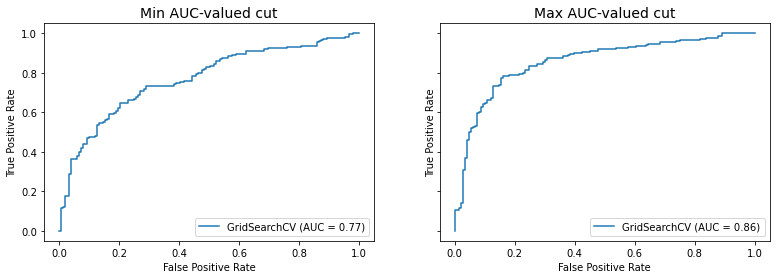

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.71, Precision: 0.75, Recall: 0.68, F1: 0.71, AUC: 0.77.
	Parameters used in the model: {'C': 0.23357214690901212, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.80, Precision: 0.83, Recall: 0.79, F1: 0.81, AUC: 0.86.
	Parameters used in the model: {'C': 0.615848211066026, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Standardized dataset ROC for min and max AUC value


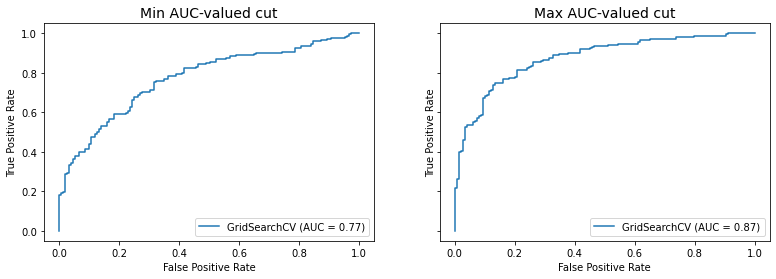

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.70, Precision: 0.76, Recall: 0.65, F1: 0.70, AUC: 0.77.
	Parameters used in the model: {'C': 0.08858667904100823, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.79, Precision: 0.80, Recall: 0.82, F1: 0.81, AUC: 0.87.
	Parameters used in the model: {'C': 0.08858667904100823, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

BetterFE dataset ROC for min and max AUC value


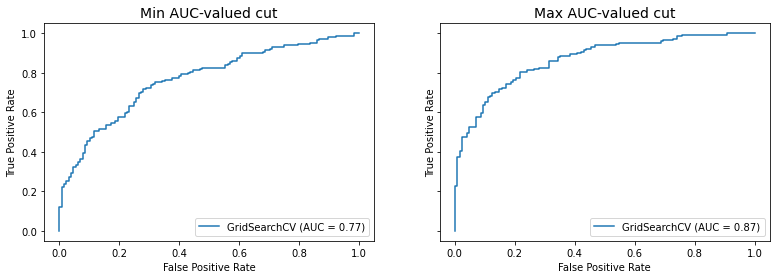

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.70, Precision: 0.74, Recall: 0.68, F1: 0.71, AUC: 0.78.
	Parameters used in the model: {'C': 0.615848211066026, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.79, Precision: 0.78, Recall: 0.85, F1: 0.81, AUC: 0.85.
	Parameters used in the model: {'C': 1.623776739188721, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Mean results of the metrics for the model with the training data
Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.740422   0.75942  0.741228  0.755026  0.815821  0.00800061
Max    0.75215   0.77429  0.766082  0.765706  0.823026   0.0100002
Mean   0.74527  0.765555  0.754971  0.760177  0.818622  0.00900016

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min  

In [10]:
# Print the calculated results in a tabular way
plotCalculatedResults(logisticRegressionCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(logisticRegressionCalculatedResults, logisticRegressionResults, _testResults)

# Print the calculated results in a tabular way for the training set.
#   to compare the data in order to search for overfitting or underfitting.
print("Mean results of the metrics for the model with the training data")
plotCalculatedResults(logisticRegressionCalculatedResultsTrain)

### K-Nearest-Neighbor execution

In [11]:
print("Running K-Nearest-Neighbor...")

# Execute logistic regression for each cut of each dataset and get the results.
KNNResults = runModel(doKNN)

# Get the calculated mean, the min and the max for every metric.
KNNCalculatedResults = processAlgorithmResults(KNNResults, _testResults)
KNNCalculatedResultsTrain = processAlgorithmResults(KNNResults, _trainResults)

Running K-Nearest-Neighbor...
Start for Normalized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for Standardized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for BetterFE dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!


### K-Nearest-Neighbor summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.734375  0.743169  0.754386  0.752187  0.836022  0.00499773
Max   0.853125  0.848315  0.883041   0.86533  0.920778  0.00700068
Mean  0.789312  0.790057  0.825614   0.80716  0.876487  0.00571598

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.746875  0.743316   0.77193  0.765217  0.839593  0.00500035
Max   0.834375  0.846626  0.894737      0.85  0.921504  0.00705385
Mean  0.787438  0.784363  0.831462  0.806874  0.879295  0.00613094

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.750903  0.746914  0.765101  0.770764  0.828151  0.00399876
Max   0.833935   0.84507  0.892617   0.84984  0.917943  0.00600076
Mean  0.795523  0.796557  0.833691  0.814227  0.883227  0.00481036

Normalized dataset ROC for min and max AUC value


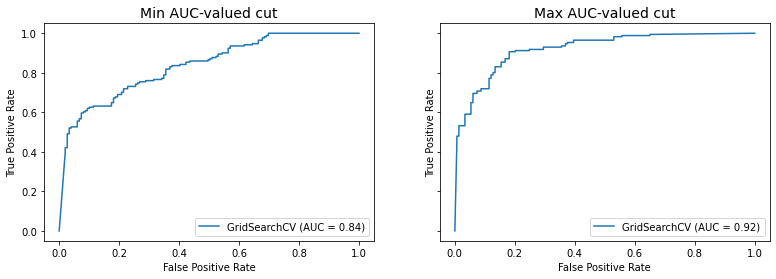

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.73, Precision: 0.75, Recall: 0.75, F1: 0.75, AUC: 0.84.
	Parameters used in the model: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.85, Precision: 0.85, Recall: 0.88, F1: 0.87, AUC: 0.92.
	Parameters used in the model: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Standardized dataset ROC for min and max AUC value


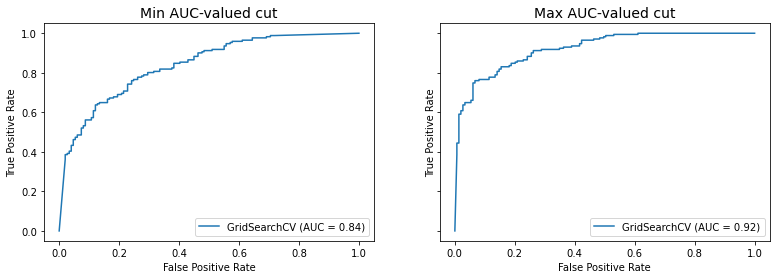

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.76, Precision: 0.76, Recall: 0.80, F1: 0.78, AUC: 0.84.
	Parameters used in the model: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.82, Precision: 0.80, Recall: 0.87, F1: 0.83, AUC: 0.92.
	Parameters used in the model: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

BetterFE dataset ROC for min and max AUC value


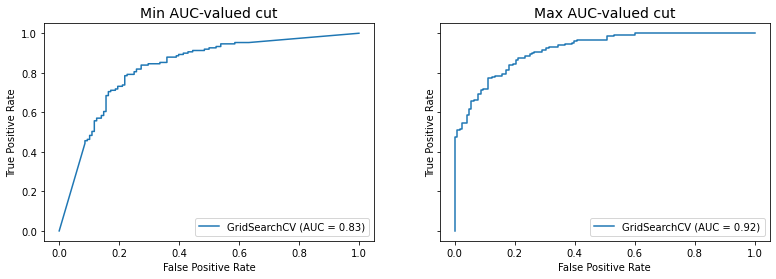

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.78, Precision: 0.79, Recall: 0.80, F1: 0.80, AUC: 0.87.
	Parameters used in the model: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.83, Precision: 0.81, Recall: 0.88, F1: 0.85, AUC: 0.92.
	Parameters used in the model: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

Mean results of the metrics for the model with the training data
Normalized dataset metrics summary
     Accuracy Precision Recall F1 AUC  Refit Time
Min         1         1      1  1   1  0.00499988
Max         1         1      1  1   1    0.006001
Mean        1         1      1  1   1  0.00540018

Standardized dataset metrics summary
     Accuracy Precision Recall F1 AUC  Refit Time
Min         1         1      1  1   1  0.00599909
Max         1         1      1  1

In [12]:
# Print the calculated results in a tabular way
plotCalculatedResults(KNNCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(KNNCalculatedResults, KNNResults, _testResults)

# Print the calculated results in a tabular way for the training set.
#   to compare the data in order to search for overfitting or underfitting.
print("Mean results of the metrics for the model with the training data")
plotCalculatedResults(KNNCalculatedResultsTrain)

### Decision Tree execution

In [13]:
print("Running Decision Tree...")

# Execute logistic regression for each cut of each dataset and get the results.
decisionTreeResults = runModel(doDecisionTree)

# Get the calculated mean, the min and the max for every metric.
decisionTreeCalculatedResults = processAlgorithmResults(decisionTreeResults, _testResults)
decisionTreeCalculatedResultsTrain = processAlgorithmResults(decisionTreeResults, _trainResults)

Running Decision Tree...
Start for Normalized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for Standardized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for BetterFE dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!


### Decision Tree summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min     0.6875  0.690355  0.701754  0.714286  0.703207  0.00499606
Max   0.828125  0.827381  0.888889  0.846797  0.823639   0.0110104
Mean  0.751313  0.767694  0.768889   0.76751   0.75988  0.00705692

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min      0.625  0.652695  0.637427   0.64497  0.666255  0.00598669
Max        0.8  0.812121  0.842105  0.818182  0.824856   0.0110009
Mean  0.740875  0.755526  0.762573  0.758607  0.747375  0.00703089

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.685921  0.698718  0.651007  0.704225  0.681601  0.00399542
Max   0.812274  0.818841  0.852349  0.830065  0.828387  0.00899935
Mean  0.739061  0.760019   0.75396  0.756199  0.742965  0.00572521

Normalized dataset ROC for min and max AUC value


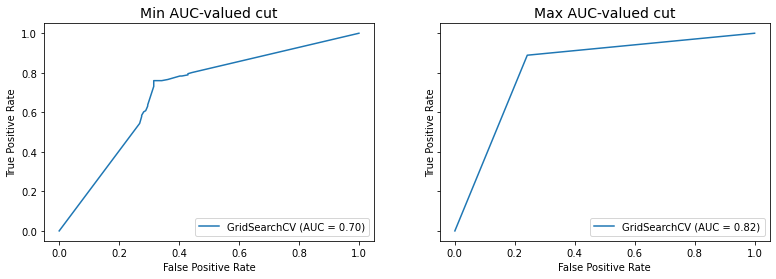

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.72, Precision: 0.73, Recall: 0.76, F1: 0.75, AUC: 0.70.
	Parameters used in the model: {'criterion': 'gini', 'max_depth': 13, 'max_features': None, 'splitter': 'random'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.83, Precision: 0.81, Recall: 0.89, F1: 0.85, AUC: 0.82.
	Parameters used in the model: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'splitter': 'random'}

Standardized dataset ROC for min and max AUC value


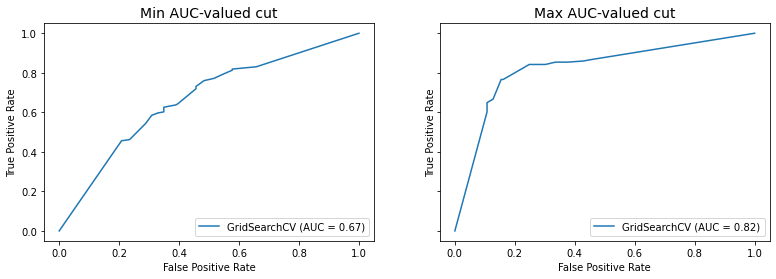

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.62, Precision: 0.65, Recall: 0.64, F1: 0.64, AUC: 0.67.
	Parameters used in the model: {'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'splitter': 'random'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.80, Precision: 0.80, Recall: 0.84, F1: 0.82, AUC: 0.82.
	Parameters used in the model: {'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'splitter': 'random'}

BetterFE dataset ROC for min and max AUC value


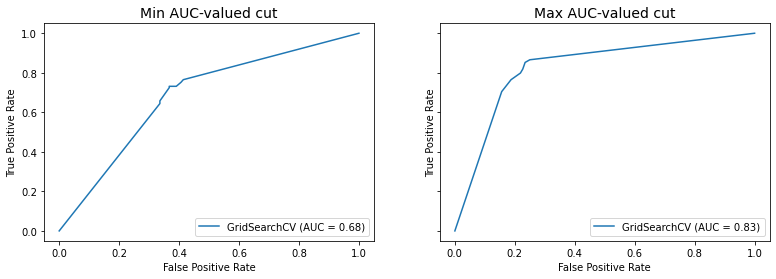

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.68, Precision: 0.68, Recall: 0.76, F1: 0.72, AUC: 0.68.
	Parameters used in the model: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'splitter': 'best'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.78, Precision: 0.77, Recall: 0.84, F1: 0.80, AUC: 0.80.
	Parameters used in the model: {'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'splitter': 'best'}

Mean results of the metrics for the model with the training data
Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.860829  0.862464  0.880117  0.871201  0.946264  0.00500011
Max          1         1         1         1         1   0.0109997
Mean  0.951837  0.953608  0.957018   0.95526  0.986384  0.00679975

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.912432   0.96129  0.871345   0.91411  

In [14]:
# Print the calculated results in a tabular way
plotCalculatedResults(decisionTreeCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(decisionTreeCalculatedResults, decisionTreeResults, _testResults) 

# Print the calculated results in a tabular way for the training set.
#   to compare the data in order to search for overfitting or underfitting.
print("Mean results of the metrics for the model with the training data")
plotCalculatedResults(decisionTreeCalculatedResultsTrain)

### Neural Network execution

In [15]:
print("Running Neural Network...")

# Execute logistic regression for each cut of each dataset and get the results.
neuralNetworkResults = runModel(doNeuralNetwork)

# Get the calculated mean, the min and the max for every metric.
neuralNetworkCalculatedResults = processAlgorithmResults(neuralNetworkResults, _testResults)
neuralNetworkCalculatedResultsTrain = processAlgorithmResults(neuralNetworkResults, _trainResults)

Running Neural Network...
Start for Normalized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for Standardized dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!
Start for BetterFE dataset
	Running cut 10... done!
	Running cut 20... done!
	Running cut 30... done!
	Running cut 40... done!
	Running cut 50... done!


### Neural Network summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min        0.7  0.724551  0.678363  0.713846  0.778523   0.394002
Max     0.7875  0.823129  0.812865  0.803468  0.860591    1.99137
Mean  0.750437  0.776498  0.749006  0.762103  0.824674   0.858162

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min   0.715625  0.726776  0.695906  0.723404  0.787865   0.775001
Max     0.8125  0.840278  0.842105  0.827586  0.874289    3.40814
Mean  0.758437  0.777115  0.769942  0.772893  0.830803    2.20778

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min   0.707581   0.72327   0.66443  0.709677  0.778104   0.342001
Max   0.794224  0.824427  0.845638  0.807692  0.879352      2.754
Mean  0.747798  0.777799  0.745101  0.760311  0.827859    1.28469

Normalized dataset ROC for min and max AUC value


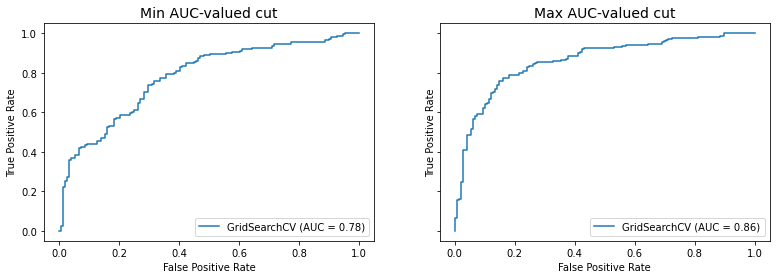

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.72, Precision: 0.74, Recall: 0.73, F1: 0.74, AUC: 0.78.
	Parameters used in the model: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'max_iter': 1000, 'solver': 'adam'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.79, Precision: 0.81, Recall: 0.79, F1: 0.80, AUC: 0.86.
	Parameters used in the model: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (13,), 'max_iter': 1500, 'solver': 'adam'}

Standardized dataset ROC for min and max AUC value


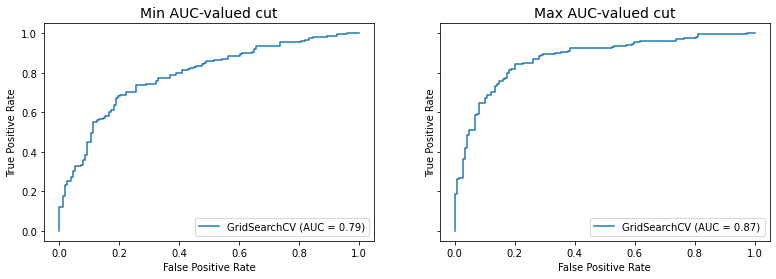

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.72, Precision: 0.76, Recall: 0.70, F1: 0.73, AUC: 0.79.
	Parameters used in the model: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (9,), 'max_iter': 1000, 'solver': 'adam'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.81, Precision: 0.81, Recall: 0.84, F1: 0.83, AUC: 0.87.
	Parameters used in the model: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (19,), 'max_iter': 1000, 'solver': 'adam'}

BetterFE dataset ROC for min and max AUC value


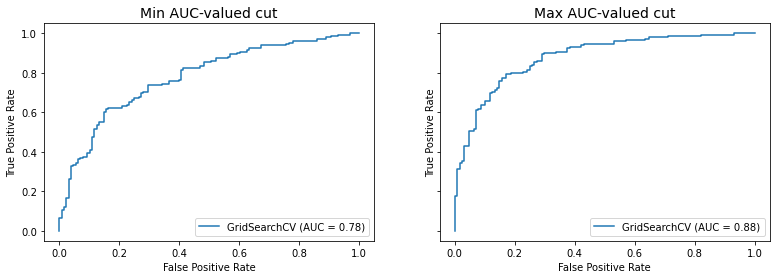

Min AUC-valued cut (left plot)
	Metrics for this model. Accuracy: 0.70, Precision: 0.74, Recall: 0.68, F1: 0.71, AUC: 0.81.
	Parameters used in the model: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (14,), 'max_iter': 1000, 'solver': 'adam'}
Max AUC-valued cut (right plot)
	Metrics for this model: Accuracy: 0.79, Precision: 0.79, Recall: 0.84, F1: 0.81, AUC: 0.86.
	Parameters used in the model: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (16,), 'max_iter': 1000, 'solver': 'adam'}

Mean results of the metrics for the model with the training data
Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min   0.742768  0.766117  0.747076  0.756477  0.816389   0.426001
Max   0.768569  0.790199   0.77924  0.782673   0.84543      1.522
Mean  0.756841  0.778517  0.762281  0.770254  0.832781     1.0472

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min   0.7802

In [16]:
# Print the calculated results in a tabular way
plotCalculatedResults(neuralNetworkCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(neuralNetworkCalculatedResults, neuralNetworkResults, _testResults)

# Print the calculated results in a tabular way for the training set.
#   to compare the data in order to search for overfitting or underfitting.
print("Mean results of the metrics for the model with the training data")
plotCalculatedResults(neuralNetworkCalculatedResultsTrain)

In [17]:
# Save the results. We're saving in a json file.
def saveResults(data, filename):
    # Build the path.
    pathFile = os.path.join(os.getcwd(), "Values", filename + ".json")

    # Data to dump.
    dataToDump = {}

    # Create a new dictionary without the models, just the metrics.
    # For each dataset.
    for dataset in _datasets:
        dataToDump[dataset] = []

        # For each partial result.
        for partialResult in data[dataset]:

            partialResultTemp = {}

            # For each metric.
            for metric in _metrics:
                partialResultTemp[metric] = partialResult[metric]

            dataToDump[dataset].append(partialResultTemp)

    # Create the json string file.
    jsonObject = json.dumps(dataToDump, indent=2)

    # Save the json string file.
    with open(pathFile, "w") as jsonFile:
        jsonFile.write(jsonObject)

# Save all the results.
saveResults(logisticRegressionResults, "logisticRegressionResults")
saveResults(KNNResults , "KNNResults")
saveResults(decisionTreeResults , "decisionTreeResults")
saveResults(neuralNetworkResults , "neuralNetworkResults")

In [18]:
print("Done!")

Done!
